In [2]:
#import modules 
import numpy as np
import os
import pickle # to read and store fetures

# is used to create progress bars for data processing, 
#training machine learning models, multi-loop Python function, 
#and downloading data from the internet
from tqdm.notebook import tqdm

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# to onvert the string into number sequence
from tensorflow.keras.preprocessing.text import Tokenizer

#this is to even out the lines that are short or long
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model

#to_catogorical converts a class vector to binary metrix with each column as onehotEncoded
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [4]:
#setting directory 

#directory of data set
BASE_DIR = '/content/drive/MyDrive/obj_detct_tanish/archive-2'

#working directory
WORKING_DIR = '/content/drive/MyDrive/obj_detct_tanish'

In [5]:
# load vgg16 model = to extract fetures of the image
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
#print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step


In [6]:
 # extract features from image

features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # preprocess image for vgg = ie to create a batch of images
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [7]:
# store features in pickle - this helps saving turn of time for models

#will use later as features dictionary 
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
#laoding fetures (rb=read binary)
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

***# loading the captions data ---***

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)#this line is used to skip first line as in data its discritpion 
    captions_doc = f.read()#this will read whole text day

In [9]:
# create mapping of image to captions 
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):#to take line by line
    # split the line by comma(,) ie after the image name
    tokens = line.split(',') # token given to image and its caption 
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]#imagename,caption
    # remove extension from image ID
    image_id = image_id.split('.')[0]#to remove extention 
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption as a single image can have multiple captions 
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping) # to check that all images are concated

8091

## #preprocessing image **bold text**

In [11]:

def clean(mapping):
    for key, captions in mapping.items():
      #key = image
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')#to delete all chars except a-zA-Z
            # delete additional spaces ie delete more than one space
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption , also remove the characters with single lenght 
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            #to rewrite the original caption
            captions[i] = caption

In [12]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# function to preprocess the text 
clean(mapping)

In [14]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
#this is to provide the index of each word in the sentence
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
# tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)# generate token
vocab_size = len(tokenizer.word_index) + 1 #len of vocab of unique words is word_index

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length #future use to pad the sequence 

35

# Train Test **Split** 

In [20]:
# spliting
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)# ratio is 90,10
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# this is the method that is used  to pad the sequence for in_seq 

# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [21]:
# create data generator to get data in batch (-----avoids session crash)

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0# to determine the end of batch size 
    while 1:
        for key in data_keys:# image dic
            n += 1#to strt till reaching batch size
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0] # list of the index 
                #of a particular caption

                # split the sequence into X, y pairs , x=input y=output
                for i in range(1, len(seq)):
                    # split into input and output pairs , this is the pairs till the last word
                    in_seq, out_seq = seq[:i], seq[i] # first word and then currrent word
                    # pad input sequence if less than the max lenght 
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]#to append padding at first
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] #one hot encoding type , binary encode 
                    
                    # store the sequences
                    X1.append(features[key][0])#feture maps
                    X2.append(in_seq)#padded seq
                    y.append(out_seq)#encoded seq
            #use mentioned feture map
            if n == batch_size:
              #convert to array
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                #work as a return statement 
                # input yeild , output
                yield [X1, X2], y
                #re initialize
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

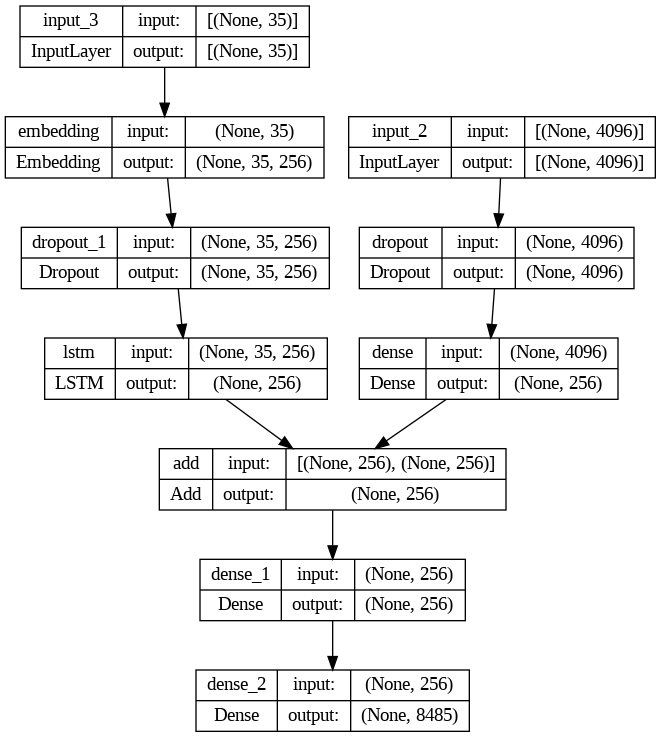

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))#input layer , input is acc to the model used ie vgg16
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))# senetences for the max lenght 

     #input dim,output_dim,mask
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)# to convert into dense vectors of fixed size
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2) 

# decoder model
decoder1 = add([fe2, se3]) # concate features with the captions
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)# we have two input and one output
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [23]:
 # train the model
epochs = 25
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 27s 120ms/step - loss: 2.0915


In [24]:
model.save(WORKING_DIR+'/image_caption_model.h5')

## ** Generate the captions for the model**

In [25]:
def idx_to_word(integer, tokenizer):
  #to convert index into word all the words we get will be in the form of index
    for word, index in tokenizer.word_index.items():
      #so if integer is eqqual to predicted index than return the word
        if index == integer:
            return word
    return None

In [26]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process 
    in_text = 'startseq'
    # iterate over the max length of sequence ie 35
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability for the next word
        yhat = np.argmax(yhat)
        # convert index to word (function above)
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word from strt 
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [27]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image of test
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words the actual caption and predicted caption
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score = this is used when dealing with text data 
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.546166
BLEU-2: 0.321010


# ** Visualizing the results **

In [28]:

from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs playing in the grass endseq


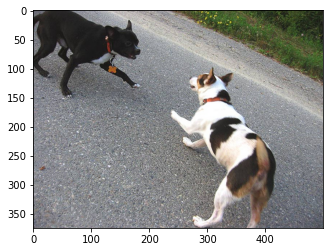

In [33]:
#generate caption tresting
generate_caption("1001773457_577c3a7d70.jpg")